# このノートでやった（できる）こと
### Logistic regressionを用いて、目的変数の確率を算出し、算出した値を元に様々な掛け方をした場合の回収率を計算

#### 計算に用いた特徴量
- 各レーサーのクラス
- 各レーサーの各枠における平均スタートタイム
- 各レーサーの連帯率
- 展示タイム
- 各モーターの2連率
- 各モーターの3連率
- 各ボートの2連率
- 各ボートの3連率

#### 目的変数
- 1枠: 1着になる (1) or ならない (0)
- 2-6枠: 3着以内にはいる (1) or 入らない (0)


### 結果
#### Logistic Regression結果
- Logistic_regression_1よりは全体的にいい結果になるが、まだ実用化にたるものとは言えない。ギャンブル性がある。
- regressionに使う結果を、半年分入れるよりも、1ヶ月分など短期にする方が予測精度が上がる可能性がある
#### bet結果


In [1]:
# 必要なモジュールのインポート

from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle
import termcolor
from datetime import datetime

import sys
import os

current_dir = os.getcwd()
sys.path.append(os.path.join(current_dir, '../conf/'))
sys.path.append(os.path.join(current_dir, '../crawl/'))
sys.path.append(os.path.join(current_dir, '../data_preparing/'))
sys.path.append(os.path.join(current_dir, 'analyzer_conf/'))

# my module
import loader
import boatrace_crawler_conf
import analyzer_conf

In [2]:
# 過去のレース結果をdfとして取得
the_merged_df = loader.main()
# dfをソート
the_merged_df = the_merged_df.sort_values(["date", "venue", "raceNumber"])

from_dt = datetime(2019, 1, 1)
to_dt = datetime(2019, 9, 1)

the_merged_df = the_merged_df[(the_merged_df["date"] >= from_dt) & (the_merged_df["date"] <= to_dt)]
# print(the_merged_df["CS_frame_1_1"])

/Users/grice/mywork/boatrace/src/analyze/../data_preparing/loader.py:357: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  race_results_supplementary_df = pd.concat(race_results_supplementary_df_list)


In [35]:
# logistic regressionを利用した学習

def make_df_for_analyze(merged_df, fv_list, column_list_label, odds_list):
    """
    parameters
        fv_list: dfのうち、特徴量として用いるカラム名のリスト
        column_list_label: dfのうち、labelとして用いるカラム名のリスト
    """
    
    # 特徴量のdfを作成
    fv_df = merged_df[fv_list]
    
    # クラスカラムを，A1 =0, A2 = 1のように数字に変換する
    class_dict = {"A1": 0, "A2":1, "B1": 2, "B2": 3}
    for key, value in class_dict.items():
        fv_df.replace(key, value, inplace = True)

    # 会場名をbooleanに変換
    venue_df = pd.get_dummies(fv_df["venue"])
    
    # fv_dfの方の会場の列を削除
    fv_df = fv_df.drop("venue", axis=1)
    
    # 会場名がbooleanになったfv_dfの作成
    fv_df = pd.concat([fv_df, venue_df], axis=1)
    
    # なぜかdtypeがstrになっちゃうのでfloatに戻す
    fv_df = fv_df.astype(float)
    
    # labelのdfを作成
    label_df = merged_df[column_list_label]
    
    # ラベルをbooleanに変換
    label_df = analyzer_conf.make_label_boolean_ver1(label_df, column_list_label)
    
    """
    # 特徴量を標準化
    fv_label_df = analyzer_conf.standerdize_feature_values(
        fv_label_df, column_list_label)
    """
    
    # オッズのdfを作成
    odds_df = merged_df[odds_list]
    
    # 解析用dfを作成
    fv_label_odds_df = pd.concat([fv_df, label_df, odds_df], axis=1)
    # nanを含む行を削除
    fv_label_odds_df = fv_label_odds_df.dropna()
    
    # oddsはないバージョンのdf
    fv_label_df = pd.concat([fv_df, label_df], axis=1)
    # nanを含む行を削除
    fv_label_df = fv_label_df.dropna()
    
    """
    print(len(fv_df), len(label_df), len(odds_df))
    print("解析用dfの行数は.{0}".format(len(fv_label_df)))
    print(fv_label_df)
    """
    
    return fv_label_df, fv_label_odds_df


def separate_train_test_dataset(for_analysis_df, train_data_ratio):
       
    # 解析用df（特徴量+label）を、学習用データとテストデータのarrayに分ける
    train_size = int(len(for_analysis_df) * train_data_ratio)
    train_data = for_analysis_df[:train_size].values
    test_data = for_analysis_df[train_size:].values
    
    return train_data, test_data, train_size

    
def learn_logistic_regression(train_data, column_list_label):
    
    """
    1枠が1着になるかどうか？2枠以降に関しては3着以内に入るかどうか？を scikit-lernのlogistic regressionを用いて学習する。
    複数のラベルをリストとして入力することが可能で、戻り値はそれぞれのlabelに対して学習を行なった結果のモデルを各要素にもつリスト
    
    return
        clf_list: 各ラベルについて学習したモデルのlist
    
    TODO
        ラベルの作成方法などもinput parameterとして指定できた方がいい。
        むしろregressionの方法もinputにして超汎用的な関数を外側に作るか？
    
    """
    # ラベルとしてもちいる部分の数。labelと特徴量を分ける際に使用、
    num_labels = len(column_list_label)
    
    # 特徴量部分のarray
    train_x = train_data[:, :-num_labels]

    # ロジスティック回帰を行なった結果得られるオブジェクトをリストに格納
    clf_list  = []

    for i, column_label in enumerate(column_list_label):
        # ラベルを指定
        train_t = train_data[:, - num_labels + i]

        # ロジスティック回帰
        clf = LogisticRegression()
        clf.fit(train_x, train_t)

        clf_list.append(clf)
    
    return clf_list, num_labels


# ----------input-------------
# 解析に使う特徴量カラム
fv_list = []

# 開催地
fv_list.append("venue")    

for i in range(1, 7):
    # 各枠のレーサーのクラス
    fv_list.append("class_{0}".format(i))
    # 各枠の平均ST
    fv_list.append("aveST_frame{0}".format(i))
    
    # 勝率・二連率・三連率（全国）
    fv_list.append("win_rate_national_{0}".format(i))
    fv_list.append("place2Ratio_national_{0}".format(i))
    fv_list.append("place3Ratio_national_{0}".format(i))
    
    # 勝率・二連率・三連率（当地）
    fv_list.append("win_rate_local_{0}".format(i))
    fv_list.append("place2Ratio_local_{0}".format(i))
    fv_list.append("place3Ratio_local_{0}".format(i))
    
    # 展示タイム
    fv_list.append("exhibitionTime_{0}".format(i))
    
    # 各モーターの2連率, 3連率
    fv_list.append("motor_place2Ratio_{0}".format(i))
    fv_list.append("motor_place3Ratio_{0}".format(i))
    
    # ボートの2連率、3連率
    fv_list.append("boat_place2Ratio_{0}".format(i))
    fv_list.append("boat_place3Ratio_{0}".format(i))
    
    # 直前のレースの成績
    # for j in range(1, 12):
        # fv_list.append("CS_frame_{0}_{1}".format(i, j))
        # fv_list.append("CS_rank_{0}_{1}".format(i, j))

# 解析に使うラベルカラム: 1枠が1着になるか, 2枠以降は3着以降に入るかどうか？を予測
column_list_label = ["rank_{0}".format(i) for i in range(1,7)]

# 回収率計算に使用するオッズラベルのリスト
odds_list =  ["win", "winOdds", 
             "place_1", "placeOdds_1",
             "place_2", "placeOdds_2",
             "exacta", "exactaOdds",
             "quinella", "quinellaOdds",
             "wide_1", "wideOdds_1", 
             "wide_2", "wideOdds_2",
             "wide_3", "wideOdds_3",
             "trifecta", "trifectaOdds",
             "trio", "trioOdds"]

# データのうち、教師データとして使う割合（残りをテストデータとして用いる）
train_data_ratio = 0.7

# --------------------------------

# main

fv_label_df, fv_label_odds_df = make_df_for_analyze(the_merged_df, fv_list, column_list_label, odds_list)
train_data, test_data, train_size = separate_train_test_dataset(fv_label_df, train_data_ratio)
clf_list, num_labels = learn_logistic_regression(train_data, column_list_label)

/usr/local/lib/python3.6/site-packages/pandas/core/frame.py:3798: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  method=method)
/usr/local/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/Users/grice/mywork/boatrace/src/analyze/analyzer_conf.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  for_analysis_df.loc[for_analysis_df[column_name] != 1, column_name] = 0
/Users/grice/mywork/boatra

1号艇についてtrainデータを使った正解率は0.6665650583522035,
           testデータを使った正解率は0.6534241007925219
切片は[0.14906675]
2号艇についてtrainデータを使った正解率は0.6574203100505138,
           testデータを使った正解率は0.6556594188173136
切片は[-0.41889956]
3号艇についてtrainデータを使った正解率は0.6459676014631597,
           testデータを使った正解率は0.6425523267628531
切片は[0.08138372]
4号艇についてtrainデータを使った正解率は0.6555042675492074,
           testデータを使った正解率は0.6547449705344442
切片は[-0.08051885]
5号艇についてtrainデータを使った正解率は0.6973088312140742,
           testデータを使った正解率は0.6917293233082706
切片は[0.08970376]
6号艇についてtrainデータを使った正解率は0.7493903501132206,
           testデータを使った正解率は0.7523877260719366
切片は[0.23118693]


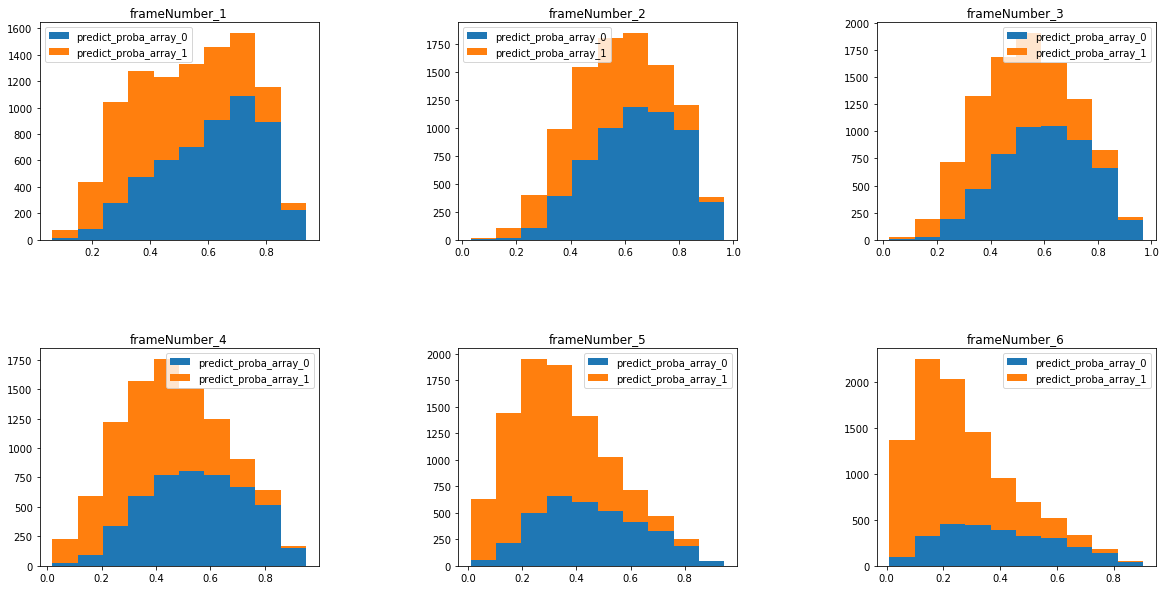

In [36]:
"""
上のセルで学習したclfを用いて色々と解析する。
今このセルで行なっている解析は
1. 各labelについて正解率を計算
2. 最適化された結果の切片および各係数を表示
3. テストデータについて、学習結果を適用した際に、ラベルが1になる確率を、実際のラベル　1 or　0で色分けしてヒストグラムを作成

"""
# 描画用の枠を用意

plt.figure(figsize=(20, 10))
plt.subplots_adjust(wspace=0.5,hspace=0.5)

# 回収率計算用に、[predict_proba_array, test_t]を各要素にもつリストを作成
predict_proba_array_list = []

# 正解率の計算などのため、train data, test dataそれぞれについて、特徴量部分のarrayとlabel部分のarrayを作成
train_x = train_data[:, :-num_labels]
test_x = test_data[:, :-num_labels]

for i, clf in enumerate(clf_list):
    train_t = train_data[:, - num_labels + i]
    test_t = test_data[:, - num_labels + i]
    
    # 正解率を計算
    train_score = clf.score(train_x, train_t)
    test_score = clf.score(test_x, test_t)
    print("{2}号艇についてtrainデータを使った正解率は{0},\n \
          testデータを使った正解率は{1}".format(train_score, test_score, i + 1))

    # 最適化された結果の切片と重みを取得
    intercept =clf.intercept_
    coef = clf.coef_
    print("切片は{0}".format(intercept))
    # for j in range (coef.shape[1]):
        # print(fv_list[j], coef[0, j], "\n")

    # テストデータについて、学習結果を適用した際に、ラベルが1になる確率を、実際のラベル　1 or　0で色分けしてヒストグラムを作成
    predict_proba_array = clf.predict_proba(test_x)
    
    # listに格納しておく
    predict_proba_array_list.append(predict_proba_array[:, 1])

    # 結果が1 (1枠が一着 , 2枠以降が3着以内) だったものの推定確率
    predict_proba_array_1 = predict_proba_array[:, 1][test_t==1]

    # 結果が0 (1枠以外が一着, 1枠以外の場合は4着以降) だったものの推定確率
    predict_proba_array_0 = predict_proba_array[:, 1][test_t==0]

    # 積み上げヒストグラムを作成
    title = "frameNumber_{0}".format(i + 1)
    labels = {'predict_proba_array_1', 'predict_proba_array_0'}
    plt.subplot(2, 3, i+1)
    plt.hist([predict_proba_array_1, predict_proba_array_0], histtype="barstacked", label=labels)
    plt.title(title)
    plt.legend()
plt.show()

# 考察
- 正解率はいずれのラベルに対しても6割から7割程度にとどまるが、test dataとtraining dataで同程度の正解率をだす。
確率ごとにプロットをしてみると、
- predict_probaが小さい時は実際に0ラベル、predict_probaが大きい時は実際に1ラベルであることがかなり多くなっている。
- 正解率を下げているのは実際に判断が難しいところ（0.3 < predict_proba < 0.7くらいの場所） であり、predict_probaが高いところ、低いところを抽出して用いることで十分に予測器として使用可能
- 1着以外が1位になる，荒れるレースの予測や、1着を1枠に固定し、2, 3を高いprobabilityを示すものでbox買するといったオプションが考えられる。

そこで、以下のセルにおいては掛け方を色々してみた時の回収率計算を行う。

In [37]:
# 計算用dfを作成
# 6列目までが上の解析によって求めた確率(1号艇が1位になる率, 2-6号艇が3位以内に入る確率)
# 7列目以降にオッズ関係の値を格納

for_calc_refund_rate_df = pd.DataFrame(np.vstack(predict_proba_array_list).T, columns=["PredProb_{0}".format(i) for i in range(1, 7)])
for odds_column_name in odds_list:
    # TODO intで入れられるものはintで。無理なものはとりあえずobjectのままで格納
    for_calc_refund_rate_df[odds_column_name] = fv_label_odds_df[odds_column_name][train_size:].values

print(for_calc_refund_rate_df)

      PredProb_1  PredProb_2  PredProb_3  PredProb_4  PredProb_5  PredProb_6  \
0       0.517474    0.801169    0.699904    0.342992    0.196805    0.193986   
1       0.326978    0.549891    0.653531    0.372629    0.246107    0.610408   
2       0.522958    0.335751    0.248016    0.597729    0.615277    0.428695   
3       0.856903    0.347753    0.514529    0.346659    0.187361    0.525144   
4       0.382160    0.819655    0.702388    0.428274    0.199201    0.156730   
5       0.400250    0.700696    0.643468    0.780372    0.140520    0.098142   
6       0.696573    0.410618    0.690265    0.453828    0.131077    0.397093   
7       0.778845    0.730865    0.525215    0.247780    0.216038    0.297243   
8       0.652621    0.652108    0.510252    0.473983    0.426838    0.091950   
9       0.662924    0.574570    0.723749    0.203111    0.715008    0.082967   
10      0.746079    0.773267    0.363155    0.400730    0.496786    0.082874   
11      0.861711    0.745169    0.547346

In [38]:
# 確率x_1以上のときのみ、1に単勝賭けした時の回収率
x_1_list = [0.6, 0.7, 0.8]
for x_1 in x_1_list:
    bet = sum(for_calc_refund_rate_df["PredProb_1"] > x_1)

    return_boolean = (for_calc_refund_rate_df["PredProb_1"] > x_1) & (for_calc_refund_rate_df["win"] == "1")
    return_ = sum(for_calc_refund_rate_df["winOdds"][return_boolean])

    print("確率{0}以上で1に単勝betした場合、的中率は{1}, 回収率は{2}".format(x_1, sum(return_boolean) / bet, return_ / (bet * 100)))

確率0.6以上で1に単勝betした場合、的中率は0.7021276595744681, 回収率は0.9239243498817967
確率0.7以上で1に単勝betした場合、的中率は0.7442505947660587, 回収率は0.9255749405233942
確率0.8以上で1に単勝betした場合、的中率は0.7985611510791367, 回収率は0.9190647482014388


In [39]:
# 1号艇の勝率x_1以上の時、他の艇で3位以内率がx_2超えがあった場合に、1-XY..の形で2連単bet

x_1_list = [0.7, 0.75, 0.8]
x_2_list = [0.5, 0.6, 0.7, 0.8]

for x_1 in x_1_list:
    for x_2 in x_2_list:
        income = 0
        bet = 0

        for index, row in for_calc_refund_rate_df.iterrows():
            if (row["PredProb_1"] > x_1):
                for j in range(2, 7):
                    if row["PredProb_{0}".format(j)] > x_2:
                        bet_num = "1-{0}".format(j)
                        bet = bet + 100
                        if row["exacta"] == bet_num:
                            income = income + row["exactaOdds"]
        print("p1が{0}以上かつ、p2-6が{1}以上で2連単betすると収益は{2}, 回収率は{3}".format(x_1, x_2, income-bet, income/bet))

p1が0.7以上かつ、p2-6が0.5以上で2連単betすると収益は-76070, 回収率は0.8281680596340637
p1が0.7以上かつ、p2-6が0.6以上で2連単betすると収益は-52560, 回収率は0.7960419091967404
p1が0.7以上かつ、p2-6が0.7以上で2連単betすると収益は-24930, 回収率は0.7919031719532554
p1が0.7以上かつ、p2-6が0.8以上で2連単betすると収益は-9460, 回収率は0.7456989247311828
p1が0.75以上かつ、p2-6が0.5以上で2連単betすると収益は-48590, 回収率は0.828546224417784
p1が0.75以上かつ、p2-6が0.6以上で2連単betすると収益は-28470, 回収率は0.8226168224299065
p1が0.75以上かつ、p2-6が0.7以上で2連単betすると収益は-13070, 回収率は0.8204670329670329
p1が0.75以上かつ、p2-6が0.8以上で2連単betすると収益は-5340, 回収率は0.7382352941176471
p1が0.8以上かつ、p2-6が0.5以上で2連単betすると収益は-17930, 回収率は0.8712849964106245
p1が0.8以上かつ、p2-6が0.6以上で2連単betすると収益は-14000, 回収率は0.8133333333333334
p1が0.8以上かつ、p2-6が0.7以上で2連単betすると収益は-4110, 回収率は0.8750759878419453
p1が0.8以上かつ、p2-6が0.8以上で2連単betすると収益は-460, 回収率は0.941025641025641


In [40]:
# 1号艇の勝率x_1以上の時、他の艇で3位以内率x_2超えがあった場合に、1-X-9と1-9-Xの形で3連単bet
x_1_list = [0.6, 0.7, 0.8]
x_2_list = [0.6, 0.7, 0.8]

for x_1 in x_1_list:
    for x_2 in x_2_list:
        
        income = 0
        bet = 0
        
        for index, row in for_calc_refund_rate_df.iterrows():
            if (row["PredProb_1"] > x_1):
                for j in range(2, 7):
                    if row["PredProb_{0}".format(j)] > x_2:
                        for k in range(2, 7):
                            if k is not j:
                                bet = bet + 200
                                bet_num_1 = "1-{0}-{1}".format(j, k)
                                bet_num_2 = "1-{0}-{1}".format(k, j)
                                # print(bet_num_1, bet_num_2, row["trifecta"], row["trifectaOdds"])
                                if row["trifecta"] == bet_num_1 or row["trifecta"] == bet_num_2:
                                    income = income + row["trifectaOdds"]
        print("p1が{0}以上かつ、p2-6が{1}以上で3連単betすると収益は{2}, 回収率は{3}".format(x_1, x_2, income-bet, income/bet))

p1が0.6以上かつ、p2-6が0.6以上で3連単betすると収益は-856480, 回収率は0.765064735571648
p1が0.6以上かつ、p2-6が0.7以上で3連単betすると収益は-374290, 回収率は0.7865590784671533
p1が0.6以上かつ、p2-6が0.8以上で3連単betすると収益は-186700, 回収率は0.6745118549511855
p1が0.7以上かつ、p2-6が0.6以上で3連単betすると収益は-481520, 回収率は0.7664338377958867
p1が0.7以上かつ、p2-6が0.7以上で3連単betすると収益は-218380, 回収率は0.7721410684474124
p1が0.7以上かつ、p2-6が0.8以上で3連単betすると収益は-93520, 回収率は0.685752688172043
p1が0.8以上かつ、p2-6が0.6以上で3連単betすると収益は-152200, 回収率は0.7463333333333333
p1が0.8以上かつ、p2-6が0.7以上で3連単betすると収益は-63640, 回収率は0.7582066869300912
p1が0.8以上かつ、p2-6が0.8以上で3連単betすると収益は-12820, 回収率は0.794551282051282


In [41]:
# 上と同じノリで2着固定。すなわち、
# 1号艇の勝率x_1以上の時、他の艇で3位以内率x_2超えがあった場合に、1-X-9の形で3連単bet
x_1_list = [0.5, 0.6, 0.7, 0.8]
x_2_list = [0.4, 0.5, 0.6, 0.7, 0.8]

for x_1 in x_1_list:
    for x_2 in x_2_list:
        
        income = 0
        bet = 0
        
        for index, row in for_calc_refund_rate_df.iterrows():
            if (row["PredProb_1"] > x_1):
                for j in range(2, 7):
                    if row["PredProb_{0}".format(j)] > x_2:
                        for k in range(2, 7):
                            if k is not j:
                                bet = bet + 100
                                bet_num = "1-{0}-{1}".format(j, k)
                                if row["trifecta"] == bet_num:
                                    income = income + row["trifectaOdds"]
        print("p1が{0}以上かつ、p2-6が{1}以上で3連単betすると収益は{2}, 回収率は{3}".format(x_1, x_2, income-bet, income/bet))

p1が0.5以上かつ、p2-6が0.4以上で3連単betすると収益は-1577480, 回収率は0.7473444807482863
p1が0.5以上かつ、p2-6が0.5以上で3連単betすると収益は-1033660, 回収率は0.7614997692662667
p1が0.5以上かつ、p2-6が0.6以上で3連単betすると収益は-628370, 回収率は0.7616922026699029
p1が0.5以上かつ、p2-6が0.7以上で3連単betすると収益は-347280, 回収率は0.7388086642599277
p1が0.5以上かつ、p2-6が0.8以上で3連単betすると収益は-135290, 回収率は0.7109188034188034
p1が0.6以上かつ、p2-6が0.4以上で3連単betすると収益は-1068680, 回収率は0.7621561470666786
p1が0.6以上かつ、p2-6が0.5以上で3連単betすると収益は-706030, 回収率は0.7706801351175783
p1が0.6以上かつ、p2-6が0.6以上で3連単betすると収益は-427590, 回収率は0.7654213298222515
p1が0.6以上かつ、p2-6が0.7以上で3連単betすると収益は-221200, 回収率は0.7477189781021898
p1が0.6以上かつ、p2-6が0.8以上で3連単betすると収益は-85820, 回収率は0.7007670850767085
p1が0.7以上かつ、p2-6が0.4以上で3連単betすると収益は-521040, 回収率は0.8016143770941212
p1が0.7以上かつ、p2-6が0.5以上で3連単betすると収益は-345090, 回収率は0.8051219787666591
p1が0.7以上かつ、p2-6が0.6以上で3連単betすると収益は-233980, 回収率は0.773011253395421
p1が0.7以上かつ、p2-6が0.7以上で3連単betすると収益は-109980, 回収率は0.7704924874791319
p1が0.7以上かつ、p2-6が0.8以上で3連単betすると収益は-43140, 回収率は0.7100806451612903
p1が0.8以上かつ

In [42]:
# 1号艇の勝率x_1以上の時、他の艇で3位以内率x_2以下が2艇以上あった場合に、1頭で、2割以下艇を外した残りを2, 3着boxにして買う
x_1_list = [0.6, 0.7, 0.8]
x_2_list = [0.4, 0.3, 0.2]

for x_1 in x_1_list:
    for x_2 in x_2_list:
        
        income = 0
        bet = 0
        
        for index, row in for_calc_refund_rate_df.iterrows():
            if (row["PredProb_1"] > x_1):
                outers = (row[["PredProb_{0}".format(n) for n in range(2, 7)]] < x_2)
                num_outers = sum(outers)
                if (num_outers > 1):
                    for j in range(2, 7):
                        if row["PredProb_{0}".format(j)] > x_2:
                            for k in range(2, 7):
                                if k is not j and row["PredProb_{0}".format(k)] > x_2:
                                    bet = bet + 100
                                    bet_num = "1-{0}-{1}".format(j, k)
                                    if row["trifecta"] == bet_num:
                                        income = income + row["trifectaOdds"]
        print("p1が{0}以上かつ、p2-6が{1}以上で3連単betすると収益は{2}, 回収率は{3}".format(x_1, x_2, income-bet, income/bet))

p1が0.6以上かつ、p2-6が0.4以上で3連単betすると収益は-286720, 回収率は0.8241413150147203
p1が0.6以上かつ、p2-6が0.3以上で3連単betすると収益は-203030, 回収率は0.828086367485182
p1が0.6以上かつ、p2-6が0.2以上で3連単betすると収益は-36530, 回収率は0.863183520599251
p1が0.7以上かつ、p2-6が0.4以上で3連単betすると収益は-152690, 回収率は0.8411795298522987
p1が0.7以上かつ、p2-6が0.3以上で3連単betすると収益は-113060, 回収率は0.8489310529128808
p1が0.7以上かつ、p2-6が0.2以上で3連単betすると収益は-31550, 回収率は0.8211451247165533
p1が0.8以上かつ、p2-6が0.4以上で3連単betすると収益は-43720, 回収率は0.8555188367481824
p1が0.8以上かつ、p2-6が0.3以上で3連単betすると収益は-17720, 回収率は0.9315301391035549
p1が0.8以上かつ、p2-6が0.2以上で3連単betすると収益は-6880, 回収率は0.8725925925925926


In [43]:
# 1号艇の勝率x_1以上の時、他の艇で3位以内率x_2以上が2艇以上あった場合に、1頭で、x_2以上艇を2, 3着boxにして買う
x_1_list = [0.5, 0.6, 0.7, 0.75, 0.8]
x_2_list = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8]

for x_1 in x_1_list:
    for x_2 in x_2_list:
        
        income = 0
        bet = 0
        
        for index, row in for_calc_refund_rate_df.iterrows():
            if (row["PredProb_1"] > x_1):
                for j in range(2, 7):
                    if row["PredProb_{0}".format(j)] > x_2:
                        for k in range(2, 7):
                            if k is not j and row["PredProb_{0}".format(k)] > x_2:
                                bet = bet + 100
                                bet_num = "1-{0}-{1}".format(j, k)
                                if row["trifecta"] == bet_num:
                                    income = income + row["trifectaOdds"]
                                # print(bet_num, row["trifecta"], row["trifectaOdds"], bet, income)
        try:
            text = "p1が{0}以上かつ、p2-6が{1}以上で3連単betすると収益は{2}, 回収率は{3}".format(x_1, x_2, income-bet, income/bet)
            if (income / bet) < 1:
                text = termcolor.colored(text, "red")
            print(text)
        except ZeroDivisionError:
            print("投票候補なし")

p1が0.5以上かつ、p2-6が0.3以上で3連単betすると収益は-1129770, 回収率は0.7894263028405278
p1が0.5以上かつ、p2-6が0.4以上で3連単betすると収益は-545800, 回収率は0.813248477383152
p1が0.5以上かつ、p2-6が0.5以上で3連単betすると収益は-211770, 回収率は0.8243447246184472
p1が0.5以上かつ、p2-6が0.6以上で3連単betすると収益は-41890, 回収率は0.8805191100969766
p1が0.5以上かつ、p2-6が0.7以上で3連単betすると収益は-10290, 回収率は0.8285
p1が0.5以上かつ、p2-6が0.8以上で3連単betすると収益は-1940, 回収率は0.4294117647058823
p1が0.6以上かつ、p2-6が0.3以上で3連単betすると収益は-758410, 回収率は0.8027337044165843
p1が0.6以上かつ、p2-6が0.4以上で3連単betすると収益は-352340, 回収率は0.827992579574302
p1が0.6以上かつ、p2-6が0.5以上で3連単betすると収益は-151370, 回収率は0.8139503441494592
p1が0.6以上かつ、p2-6が0.6以上で3連単betすると収益は-26240, 回収率は0.8815884476534296
p1が0.6以上かつ、p2-6が0.7以上で3連単betすると収益は-6640, 回収率は0.8175824175824176
p1が0.6以上かつ、p2-6が0.8以上で3連単betすると収益は-140, 回収率は0.9125
p1が0.7以上かつ、p2-6が0.3以上で3連単betすると収益は-437370, 回収率は0.8013038342722152
p1が0.7以上かつ、p2-6が0.4以上で3連単betすると収益は-189270, 回収率は0.8373689637394741
p1が0.7以上かつ、p2-6が0.5以上で3連単betすると収益は-83050, 回収率は0.8126128158844765
p1が0.7以上かつ、p2-6が0.6以上で3連単betすると収益は-17110, 回収率は

In [44]:
# 1号艇の勝率x_1以上の時、他の艇で3位以内率x_2以上が1艇, X_3以上が1艇以上あった場合に、1頭で、x_2以上艇を2, 3着boxにして買う
# ただし、2-6号艇のうち二つ以上の艇がx_２を超えていた場合、それらに対しては2倍のbet額になるアルゴリズムになっている
x_1_list = [0.6, 0.7, 0.75, 0.8]
x_2_list = [0.6, 0.7, 0.8]
x_3_list = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8]

for x_1 in x_1_list:
    for x_2 in x_2_list:
        for x_3 in x_3_list:
            if x_3 <= x_2:

                income = 0
                bet = 0

                for index, row in for_calc_refund_rate_df.iterrows():
                    if (row["PredProb_1"] > x_1):
                        for j in range(2, 7):
                            if row["PredProb_{0}".format(j)] > x_2:
                                for k in range(2, 7):
                                    if k is not j and row["PredProb_{0}".format(k)] > x_3:
                                        bet = bet + 200
                                        bet_num_1 = "1-{0}-{1}".format(j, k)
                                        bet_num_2 = "1-{0}-{1}".format(k, j)

                                        if row["trifecta"] == bet_num_1 or row["trifecta"] == bet_num_2:
                                            income = income + row["trifectaOdds"]
                                        # print(bet_num, row["trifecta"], row["trifectaOdds"], bet, income)
                try:
                    text = "p1が{0}以上かつ、p2が{1}以上かつp3が{2}で3連単betすると収益は{3}, 回収率は{4}".format(x_1, x_2, x_3, income-bet, income/bet)
                    if (income / bet) < 1:
                        text = termcolor.colored(text, "red")
                    print(text)
                except ZeroDivisionError:
                    print("p1={0}, p2={1}, p3={2}の時、投票候補なし".format(x_1, x_2, x_3))

p1が0.6以上かつ、p2が0.6以上かつp3が0.3で3連単betすると収益は-354150, 回収率は0.8308416125334352
p1が0.6以上かつ、p2が0.6以上かつp3が0.4で3連単betすると収益は-223420, 回収率は0.8447825482840072
p1が0.6以上かつ、p2が0.6以上かつp3が0.5で3連単betすると収益は-147670, 回収率は0.8289272474513438
p1が0.6以上かつ、p2が0.6以上かつp3が0.6で3連単betすると収益は-52480, 回収率は0.8815884476534296
p1が0.6以上かつ、p2が0.7以上かつp3が0.3で3連単betすると収益は-148510, 回収率は0.8421114182436743
p1が0.6以上かつ、p2が0.7以上かつp3が0.4で3連単betすると収益は-101190, 回収率は0.8400411002213088
p1が0.6以上かつ、p2が0.7以上かつp3が0.5で3連単betすると収益は-52690, 回収率は0.8564305177111716
p1が0.6以上かつ、p2が0.7以上かつp3が0.6で3連単betすると収益は-20460, 回収率は0.8885620915032679
p1が0.6以上かつ、p2が0.7以上かつp3が0.7で3連単betすると収益は-13280, 回収率は0.8175824175824176
p1が0.6以上かつ、p2が0.8以上かつp3が0.3で3連単betすると収益は-35630, 回収率は0.8755935754189944
p1が0.6以上かつ、p2が0.8以上かつp3が0.4で3連単betすると収益は-21810, 回収率は0.8822354211663067
p1が0.6以上かつ、p2が0.8以上かつp3が0.5で3連単betすると収益は-8640, 回収率は0.9157894736842105
p1が0.6以上かつ、p2が0.8以上かつp3が0.6で3連単betすると収益は-9010, 回収率は0.8122916666666666
p1が0.6以上かつ、p2が0.8以上かつp3が0.7で3連単betすると収益は-7030, 回収率は0.5959770114942529
p1が0

### 2019年1月の一月に絞ってまわした場合、
下記のような特徴があり、相当うまく行っていることがわかる。正直このまま自動betアルゴリズムにできそう。
- かなりいろんな値で回収率がちゃんとプラスになる
- p1, p2の特定の値でマイナスになったりはしない
- p値を厳しく取るほど回収率は上がる傾向がある。

かと思ったけどそうでもないかな。。。

### 2019年1月から6月まで一緒にしてまわした場合
ほとんど全てのところで回収率マイナスになってしまうぞ。。。。。
p1が0.8超えかつp2, p3を0.6程度にするとプラスになる

In [74]:
# 1号艇の勝率x_1以上の時、他の艇で3位以内率x_2以上が1艇, X_3以上が1艇以上あった場合
# 1頭で、x_2以上艇を2着候補に, x_３以上の艇を3着候補にしてbet
x_1_list = [0.4, 0.5, 0.6, 0.7, 0.8]
x_2_list = [0.4, 0.5, 0.6, 0.7, 0.8]
x_3_list = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]

for x_1 in x_1_list:
    for x_2 in x_2_list:
        for x_3 in x_3_list:

            income = 0
            bet = 0

            for index, row in for_calc_refund_rate_df.iterrows():
                if (row["PredProb_1"] > x_1):
                    for j in range(2, 7):
                        if row["PredProb_{0}".format(j)] > x_2:
                            for k in range(2, 7):
                                if k is not j and row["PredProb_{0}".format(k)] > x_3:
                                    bet = bet + 100
                                    bet_num = "1-{0}-{1}".format(j, k)
                                    
                                    if row["trifecta"] == bet_num:
                                        income = income + row["trifectaOdds"]
                                    # print(bet_num, row["trifecta"], row["trifectaOdds"], bet, income)
            try:
                text = "p1が{0}以上かつ、p2が{1}以上かつp3が{2}で3連単betすると収益は{3}, 回収率は{4}".format(x_1, x_2, x_3, income-bet, income/bet)
                if (income/bet) < 1:
                    text = termcolor.colored(text, 'red')
                print(text)
            except ZeroDivisionError:
                print("p1={0}, p2={1}, p3={2}の時、投票候補なし".format(x_1, x_2, x_3))

p1が0.4以上かつ、p2が0.4以上かつp3が0で3連単betすると収益は-1885490, 回収率は0.7469140939597315
p1が0.4以上かつ、p2が0.4以上かつp3が0.1で3連単betすると収益は-1736770, 回収率は0.7576442186933102
p1が0.4以上かつ、p2が0.4以上かつp3が0.2で3連単betすると収益は-1301080, 回収率は0.784192804657566
p1が0.4以上かつ、p2が0.4以上かつp3が0.3で3連単betすると収益は-972970, 回収率は0.794658421796847
p1が0.4以上かつ、p2が0.4以上かつp3が0.4で3連単betすると収益は-644050, 回収率は0.8128958224391377
p1が0.4以上かつ、p2が0.4以上かつp3が0.5で3連単betすると収益は-402550, 回収率は0.8255773647038434
p1が0.4以上かつ、p2が0.4以上かつp3が0.6で3連単betすると収益は-227880, 回収率は0.834269090909091
p1が0.4以上かつ、p2が0.4以上かつp3が0.7で3連単betすると収益は-141950, 回収率は0.7890160523186682
p1が0.4以上かつ、p2が0.4以上かつp3が0.8で3連単betすると収益は-26500, 回収率は0.8781048758049678
p1が0.4以上かつ、p2が0.5以上かつp3が0で3連単betすると収益は-1250330, 回収率は0.7645506929798132
p1が0.4以上かつ、p2が0.5以上かつp3が0.1で3連単betすると収益は-1144910, 回収率は0.7749783805031446
p1が0.4以上かつ、p2が0.5以上かつp3が0.2で3連単betすると収益は-843500, 回収率は0.7999857725505074
p1が0.4以上かつ、p2が0.5以上かつp3が0.3で3連単betすると収益は-639300, 回収率は0.8035582595870207
p1が0.4以上かつ、p2が0.5以上かつp3が0.4で3連単betすると収益は-399230, 回収率は0.827015901902

KeyboardInterrupt: 

### 2019年1月のデータに絞ってまわした場合
一つ上のセルの結果と同様、かなり安定して回収することを見込めそう。
ただ、こっちの方が実はばらけが出そう。例えばp1 = 0.7, p2 = 0.8の時。p3が0.1と0.6で回収率プラスに出るけど、これはでかいのを一発当てただけっぽい予感がする。

### 2019年1月から6月のデータを用いた場合

In [25]:
# 1号艇以外の艇で3位以内率x_2以上が2艇あった場合に、XY(Z)のワイド
x_2_list = [0.5, 0.6, 0.7, 0.8]

for x_2 in x_2_list:

    income = 0
    bet = 0

    for index, row in for_calc_refund_rate_df.iterrows():
        for j in range(2, 7):
            if row["PredProb_{0}".format(j)] > x_2:
                for k in range(j, 7):
                    if k is not j and row["PredProb_{0}".format(k)] > x_2:
                        bet = bet + 100
                        bet_num = "{0}-{1}".format(j, k)
                        if row["wide_1"] == bet_num:
                            income = income + row["wideOdds_1"]
                        elif row["wide_2"] == bet_num:
                            income = income + row["wideOdds_2"]
                        elif row["wide_3"] == bet_num:
                            income = income + row["wideOdds_3"] 
    try:
        print("p1が{0}以上かつ、p2-6が{1}以上で3連単betすると収益は{2}, 回収率は{3}".format(x_1, x_2, income-bet, income/bet))
    except ZeroDivisionError:
        print("投票候補なし")

p1が0.8以上かつ、p2-6が0.5以上で3連単betすると収益は-19690, 回収率は0.8082765335929893
p1が0.8以上かつ、p2-6が0.6以上で3連単betすると収益は-6330, 回収率は0.7824742268041237
p1が0.8以上かつ、p2-6が0.7以上で3連単betすると収益は670, 回収率は1.1116666666666666
p1が0.8以上かつ、p2-6が0.8以上で3連単betすると収益は-20, 回収率は0.9333333333333333


In [26]:
# 1号艇の勝率x_1以上の時、他の艇で3位以内率x_2以上が2艇以上あった場合に、1-XYで3連複
x_1_list = [0.5, 0.6, 0.7, 0.8]
x_2_list = [0.5, 0.6, 0.7, 0.8]

for x_1 in x_1_list:
    for x_2 in x_2_list:
        
        income = 0
        bet = 0
        
        for index, row in for_calc_refund_rate_df.iterrows():
            if (row["PredProb_1"] > x_1):
                for j in range(2, 7):
                    if row["PredProb_{0}".format(j)] > x_2:
                        for k in range(j, 7):
                            if k is not j and row["PredProb_{0}".format(k)] > x_2:
                                bet = bet + 100
                                bet_num = "1-{0}-{1}".format(j, k)
                                if row["trio"] == bet_num:
                                    income = income + row["trioOdds"]
                                # print(bet_num, row["trio"], row["trioOdds"], bet, income)
        try:
            print("p1が{0}以上かつ、p2-6が{1}以上で3連複betすると収益は{2}, 回収率は{3}".format(x_1, x_2, income-bet, income/bet))
        except ZeroDivisionError:
            print("投票候補なし")

p1が0.5以上かつ、p2-6が0.5以上で3連複betすると収益は-10550, 回収率は0.790258449304175
p1が0.5以上かつ、p2-6が0.6以上で3連複betすると収益は-2750, 回収率は0.7405660377358491
p1が0.5以上かつ、p2-6が0.7以上で3連複betすると収益は-130, 回収率は0.91875
投票候補なし
p1が0.6以上かつ、p2-6が0.5以上で3連複betすると収益は-5130, 回収率は0.846865671641791
p1が0.6以上かつ、p2-6が0.6以上で3連複betすると収益は-710, 回収率は0.9013888888888889
p1が0.6以上かつ、p2-6が0.7以上で3連複betすると収益は200, 回収率は1.1818181818181819
投票候補なし
p1が0.7以上かつ、p2-6が0.5以上で3連複betすると収益は-1980, 回収率は0.8777777777777778
p1が0.7以上かつ、p2-6が0.6以上で3連複betすると収益は-230, 回収率は0.9342857142857143
p1が0.7以上かつ、p2-6が0.7以上で3連複betすると収益は400, 回収率は1.5714285714285714
投票候補なし
p1が0.8以上かつ、p2-6が0.5以上で3連複betすると収益は-1460, 回収率は0.496551724137931
p1が0.8以上かつ、p2-6が0.6以上で3連複betすると収益は-100, 回収率は0.8571428571428571
p1が0.8以上かつ、p2-6が0.7以上で3連複betすると収益は-100, 回収率は0.0
投票候補なし


In [27]:
# 1の確率がx_1以下のとき、2-6号艇の値がx_2以上のものに対して単勝bet
x_1_list = [0.2, 0.3, 0.4, 0.5]
x_2_list = [0.5, 0.6, 0.7, 0.8]

for x_1 in x_1_list:
    for x_2 in x_2_list:
        income = 0
        bet = 0
        for index, row in for_calc_refund_rate_df.iterrows():
            if (row["PredProb_1"] < x_1):
                for j in range(2, 7):
                    if row["PredProb_{0}".format(j)] > x_2:
                        bet_num = "{0}".format(j)
                        bet = bet + 100
                        if row["win"] == bet_num:
                            income = income + row["winOdds"]
        print("p1が{0}以下のとき、p2-6が{1}以上なら単勝betすると収益は{2}, 回収率は{3}".format(x_1, x_2, income-bet, income/bet))

p1が0.2以下のとき、p2-6が0.5以上なら単勝betすると収益は-3800, 回収率は0.638095238095238
p1が0.2以下のとき、p2-6が0.6以上なら単勝betすると収益は-3430, 回収率は0.5765432098765432
p1が0.2以下のとき、p2-6が0.7以上なら単勝betすると収益は-1160, 回収率は0.7531914893617021
p1が0.2以下のとき、p2-6が0.8以上なら単勝betすると収益は40, 回収率は1.0235294117647058
p1が0.3以下のとき、p2-6が0.5以上なら単勝betすると収益は-7160, 回収率は0.7396363636363636
p1が0.3以下のとき、p2-6が0.6以上なら単勝betすると収益は-5210, 回収率は0.7328205128205129
p1が0.3以下のとき、p2-6が0.7以上なら単勝betすると収益は-1450, 回収率は0.8644859813084113
p1が0.3以下のとき、p2-6が0.8以上なら単勝betすると収益は-360, 回収率は0.9181818181818182
p1が0.4以下のとき、p2-6が0.5以上なら単勝betすると収益は-13370, 回収率は0.7271428571428571
p1が0.4以下のとき、p2-6が0.6以上なら単勝betすると収益は-9890, 回収率は0.708259587020649
p1が0.4以下のとき、p2-6が0.7以上なら単勝betすると収益は-3830, 回収率は0.7907103825136612
p1が0.4以下のとき、p2-6が0.8以上なら単勝betすると収益は-860, 回収率は0.8925
p1が0.5以下のとき、p2-6が0.5以上なら単勝betすると収益は-21010, 回収率は0.7133697135061392
p1が0.5以下のとき、p2-6が0.6以上なら単勝betすると収益は-15710, 回収率は0.6780737704918033
p1が0.5以下のとき、p2-6が0.7以上なら単勝betすると収益は-5910, 回収率は0.7735632183908046
p1が0.5以下のとき、p2-6が0.8以上なら単勝betすると収益は-1150,